# Importing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
ii_df = pd.read_csv('incident_info.csv')
desc_df = pd.read_csv('descriptions.csv')

# Data Exploration & Cleaning

In [ ]:
ii_df.head()

,incident_url,title,date,location_of_incident,date_of_incident,date_reported,incident_details
0,https://www.torontomu.ca/community-safety-secu...,Assault,"December 21, 2023",Victoria Street and Gould Street,"Sunday, December 17, 2023 at 4:00 PM","Sunday, December 17, 2023 at 4:00 PM",TMU Security witnessed a member of the public ...
1,https://www.torontomu.ca/community-safety-secu...,Assault,"December 18, 2023",Gerrard Street East and Nelson Mandela Wak,"Thursday, December 14, 2023 at 11:15 AM","Thursday, December 14, 2023 at 11:15 AM",A TMU community member reported to TMU Securit...
2,https://www.torontomu.ca/community-safety-secu...,Assault,"December 18, 2023",Victoria Street Laneway and Dundas Street East,"Thursday, December 14, 2023 at 6:00 AM","Thursday, December 14, 2023 at 6:00 AM",A TMU community guest reported to TMU Security...
3,https://www.torontomu.ca/community-safety-secu...,Criminal Harassment,"December 13, 2023",Gould Street and Church Street,"Friday, December 08, 2023 at 11:45 PM","Friday, December 08, 2023 at 11:45 PM",A TMU community member reported to TMU Securit...
4,https://www.torontomu.ca/community-safety-secu...,Assault: Suspect Arrested,"December 13, 2023",Carlton Street and Church Street,"Friday, December 08, 2023 at 12:30 PM","Friday, December 08, 2023 at 12:30 PM",Two TMU community members reported to TMU Secu...


In [ ]:
ii_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   incident_url          796 non-null    object
 1   title                 796 non-null    object
 2   date                  796 non-null    object
 3   location_of_incident  796 non-null    object
 4   date_of_incident      796 non-null    object
 5   date_reported         795 non-null    object
 6   incident_details      796 non-null    object
dtypes: object(7)
memory usage: 43.7+ KB


## Missing

In [ ]:
ii_df['date_of_incident'] = pd.to_datetime(ii_df['date_of_incident'])
ii_df['date_reported'] = pd.to_datetime(ii_df['date_reported'])

In [ ]:
missing_date = ii_df['date_reported'].isna()
ii_df[missing_date]

,incident_url,title,date,location_of_incident,date_of_incident,date_reported,incident_details
785,https://www.torontomu.ca/community-safety-secu...,Sexual Assault,"July 27, 2018",Yonge Street and Gerrard Street West area,2018-07-22 15:16:00,NaT,Toronto Police Service published a news releas...


In [ ]:
has_date_df = ii_df[~missing_date]

diff = has_date_df['date_reported'] - has_date_df['date_of_incident']
diff.mean(), diff.median(), diff.mode()

(Timedelta('0 days 14:03:15.773584905'),
 Timedelta('0 days 00:00:00'),
 0   0 days
 dtype: timedelta64[ns])

<Axes: >

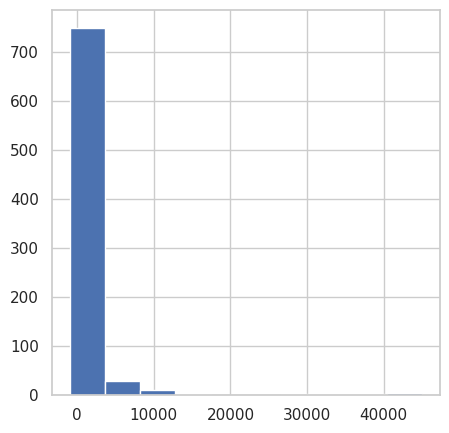

In [ ]:
diff.astype('timedelta64[m]').hist(figsize=[5,5])

date_of_incident can serve as a proxy for date_reported as it is usually the same day and time.

In [ ]:
ii_df['date_reported'] = ii_df['date_reported'].fillna(ii_df['date_of_incident'])

## Titles / Incidents

In [ ]:
ii_df.title.value_counts()

Assault                                                     341
Robbery                                                      83
Indecent Act                                                 62
Uttering Threats                                             60
Criminal Harassment                                          50
Sexual Assault                                               49
Assault: Suspect Arrested                                    40
Toronto Police Service News Release                          32
Robbery: Suspect Arrested                                    21
Mischief                                                     17
Sexual Assault: Suspect Arrested                             12
Voyeurism                                                     9
Indecent Act: Suspect Arrested                                8
Criminal Harassment: Suspect Arrested                         3
Uttering Threats: Suspect Arrested                            3
Assault: Update                         

Context:

__"Incident" and "Incident: Suspect Arrested"__ are unique incidents, with the latter being one with an arrest already made as of reporting.

__"Incident: Suspect Arrested"__ is not a follow up or update to a previously reported incident.

__"Incident: Update"__ is not a follow up or update to a previously reported incident.

Therefore we can safely ignore the suffix when aggregating them.

In [ ]:
ii_df['incident'] = ii_df.title.str.split(': ').str[0]

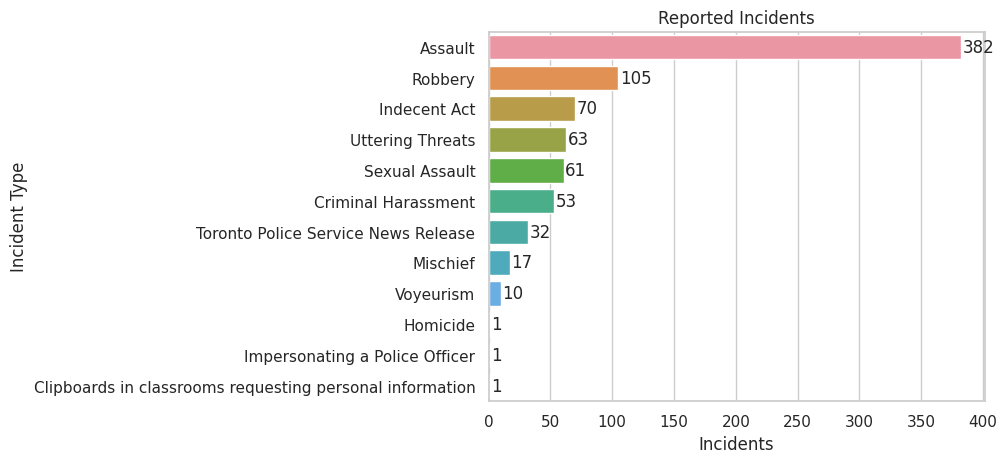

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.countplot(data=ii_df, y='incident', order=ii_df['incident'].value_counts().index)

p = plt.title('Reported Incidents')
p = plt.xlabel('Incidents')
p = plt.ylabel('Incident Type')

for p in g.patches:
    g.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
               ha='left', va='center', xytext=(1, 0), textcoords='offset points')

Making Incident Names Concise

In [ ]:
phishing = ii_df['incident'].str.contains('requesting personal')
ii_df.loc[phishing, 'incident'] = 'Phishing'

### Extracting the incident from 'Toronto Police Service News Release' details

In [ ]:
tpsnr = ii_df[ii_df['title'].str.contains('News')]

tpsnr.head()['incident_details']

17     Toronto Police Service has published a news re...
124    Toronto Police Service has published a news re...
166    Toronto Police Service has published a news re...
214    Toronto Police Service has published a news re...
238    Toronto Police Service has published a news re...
Name: incident_details, dtype: object

In [ ]:
for row in tpsnr['incident_details']:
    prefix1 = 'regarding'
    prefix2 = 'advise the community of'
    suffix1 = 'and are seeking assistance from the community'
    print(row.split(prefix1)[-1].split(prefix2)[-1].split(suffix1)[0])

 an aggravated assault investigation 
 a robbery investigation 
 an assault with a weapon investigation 
 a robbery investigation 
 a stabbing investigation 
 a robbery investigation 
 an assault arrest investigation 
 a sexual assault arrest investigation 
 an assault investigation 
 a firearm seizure investigation.
 an arrest in a sexual assault investigation.
 an arrest in a firearm investigation.
 a sexual assault investigation 
 a sexual assault investigation 
 a sexual assault investigation 
 an aggravated assault investigation 
 a shooting investigation 
 an assault investigation 
 an assault investigation 
 an online threat to schools investigation 
 a sexual assault investigation 
 an attempted child abduction investigation 
 suspected fentanyl overdoses.
 the assault that was reported to Ryerson Security on Thursday, January 30, 2020.
 a human trafficking investigaton 
 an individual wanted in a stabbing investigation 
 an individual wanted in a sexual assault investigation 


Extracted Incidents:

 incident
Assault              12
Sexual Assault        9
Robbery               3
Firearm               2
Shooting              2
Child Abduction       1
Human Trafficking     1
Overdose              1
Uttering Threats      1
dtype: int64 

Updated Distribution


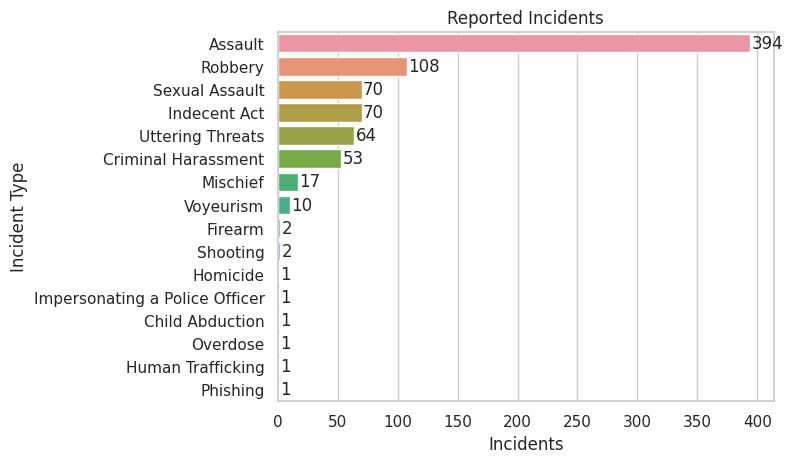

In [ ]:
def incident_from_news_release(row):
    incident_mapping = {
        'Sexual Assault': 'Sexual Assault',
        'Assault': 'Assault',
        'Criminal Harassment': 'Criminal Harassment',
        'Impersonating a Police Officer': 'Impersonating a Police Officer',
        'Homicide': 'Homicide',
        'Indecent Act': 'Indecent Act',
        'Mischief': 'Mischief',
        'Robbery': 'Robbery',
        'Uttering Threats': 'Uttering Threats',
        'Voyeurism': 'Voyeurism',

        # Only found in news releases
        'Online Threat': 'Uttering Threats',
        'Child Abduction': 'Child Abduction',
        'Overdose': 'Overdose',
        'Human Trafficking': 'Human Trafficking',
        'Stabbing': 'Assault',
        'Shooting': 'Shooting',
        'Firearm': 'Firearm',
    }

    title = row['title']
    incident = row['incident']
    incident_details = row['incident_details']

    if 'Toronto Police Service News Release' in title:
        incident = 'Unmapped Incident'

        for phrase in incident_mapping:
            if phrase.lower() in incident_details.lower():
                incident = incident_mapping[phrase]
                break

    return incident

ii_df['incident'] = ii_df.apply(lambda x: incident_from_news_release(x), axis=1)

print('Extracted Incidents:\n\n',ii_df[ii_df['title'].str.contains('News')].value_counts('incident'), '\n\nUpdated Distribution')

sns.set_theme(style="whitegrid")

g = sns.countplot(data=ii_df, y='incident', order=ii_df['incident'].value_counts().index)

p = plt.title('Reported Incidents')
p = plt.xlabel('Incidents')
p = plt.ylabel('Incident Type')

for p in g.patches:
    g.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
               ha='left', va='center', xytext=(1, 0), textcoords='offset points')

## Location of Incident

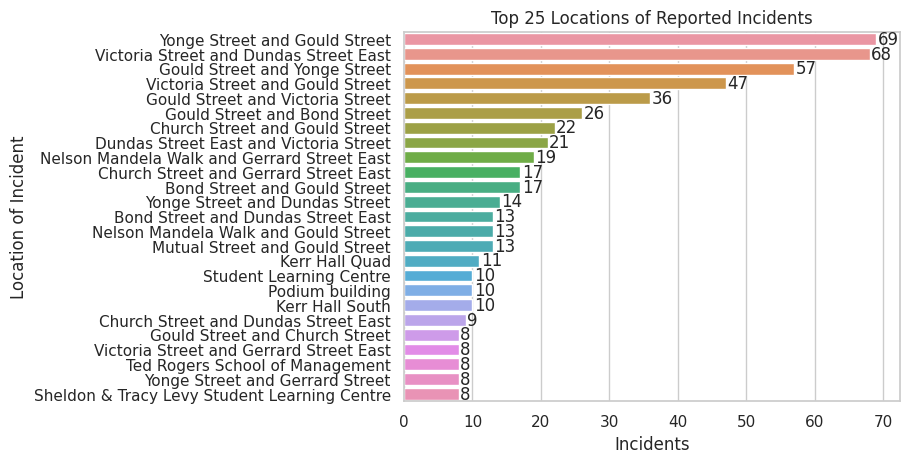

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.countplot(data=ii_df, y='location_of_incident', order=ii_df['location_of_incident'].value_counts().iloc[:25].index)

p = plt.title('Top 25 Locations of Reported Incidents')
p = plt.xlabel('Incidents')
p = plt.ylabel('Location of Incident')

for p in g.patches:
    g.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
               ha='left', va='center', xytext=(1, 0), textcoords='offset points')

**The location labels are inconsistent.**

Ordering:
*   Yonge Street and Gould Street
*   Gould Street and Yonge Street

Renaming:
*   TMU Image Centre
*   Ryerson Image Centre

Precision:
*   Tim Hortons at the Yonge- Dundas Square
*   Yonge- Dundas Square

Therefore we must standardize the names.
### Standardizing the locations


Updated Distribution



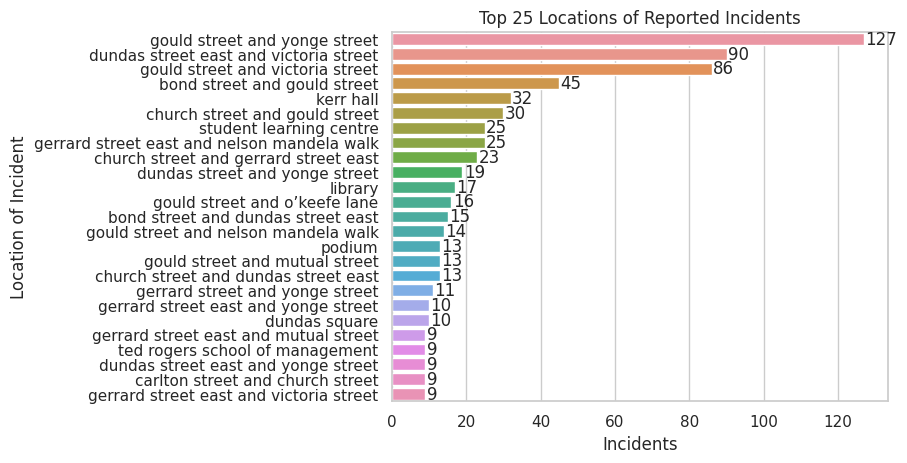

In [ ]:
def standardize_locations(location):
    location = location.strip()
    location = location.lower()

    standardize_mapping = {
        'student learning centre': 'student learning centre',
        'student learning center': 'student learning centre',
        'kerr hall': 'kerr hall',
        'mattamy athletic centre': 'mattamy athletic centre',
        'mattamy': 'mattamy athletic centre',
        'athletics centre': 'recreation and athletic centre',
        'athletic centre': 'recreation and athletic centre',
        'image arts centre': 'tmu image centre',
        'image centre': 'tmu image centre',
        'dundas square': 'dundas square',
        'rogers comm': 'rogers communications centre',
        'pitman': 'pitman hall',
        'podium': 'podium',
        'library': 'library',

        # approximate
        'yonge street between college street and dundas street': 'gerrard street and yonge street',
        '351 yonge': 'elm street and yonge street',
        '300 victoria': 'gould street and victoria street',
        '285 victoria': 'dundas street east and victoria street',
    }
    for phrase in standardize_mapping:
        if phrase in location:
            location = standardize_mapping[phrase]
            break

    excess_suffixes = ['area', 'building', 'between']

    for suffix in excess_suffixes:
        if location.endswith(suffix):
            location = location.split(' '+suffix)[0]
            break

    if ' and ' in location:
        streets = location.split(' and ')
        location = ' and '.join(sorted(streets))

    replace_mapping = {
        ' laneway': ' lane',
        'ryerson': 'tmu',
        'gold street': 'gould street',
        'bond and': 'bond street and',
        'mandela wak': 'mandela walk',
    }
    for phrase in replace_mapping:
        location = location.replace(phrase, replace_mapping[phrase])

    return location.lower().strip()

ii_df['loi_standardized'] = ii_df['location_of_incident'].apply(standardize_locations)
ii_df['loi_standardized'] = ii_df['loi_standardized'].apply(lambda x: f'{x} building' if x == 'victoria' else x)

sns.set_theme(style="whitegrid")

g = sns.countplot(data=ii_df, y='loi_standardized', order=ii_df['loi_standardized'].value_counts().iloc[:25].index)

p = plt.title('Top 25 Locations of Reported Incidents')
p = plt.xlabel('Incidents')
p = plt.ylabel('Location of Incident')

for p in g.patches:
    g.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
               ha='left', va='center', xytext=(1, 0), textcoords='offset points')
print('Updated Distribution\n')

In [ ]:
def street_name_only(street):
    words = street.split(' ')
    street_suffix = ['street', 'lane', 'walk', 'east', 'west']
    cleaned = [word for word in words if not word.isnumeric()]

    while True:
        if cleaned[-1] not in street_suffix:
            cleaned = cleaned[:-1]
        else:
            break

    return " ".join(cleaned)

def list_of_streets(location):
    contains_streets = ' street' in location or ' lane' in location

    if contains_streets:
        if ' and ' in location:
            return [street_name_only(street) for street in location.split(' and ')]
        else:
            return [street_name_only(location)]

    return ['building']

ii_df['extracted_streets'] = ii_df['loi_standardized'].apply(list_of_streets)
ii_streets_df = ii_df.explode('extracted_streets')[['incident_url', 'extracted_streets']]
ii_streets_df['extracted_streets'] = ii_streets_df['extracted_streets']

In [ ]:
ii_streets_df['extracted_streets'].value_counts()

gould street            336
yonge street            200
victoria street         192
building                155
dundas street east      142
gerrard street east      82
church street            79
bond street              61
nelson mandela walk      40
mutual street            28
dundas street            26
o’keefe lane             20
gerrard street           17
carlton street           10
dundas street west       10
jarvis street            10
college street            6
elm street                6
dalhousie street          6
victoria street lane      3
bay street                3
granby street             2
gerrard street west       2
victoria lane             1
Name: extracted_streets, dtype: int64

## Date of Incident


In [ ]:
def month_to_semester(month):
    if 9 <= month <= 12:
        return 'Fall'
    elif 1 <= month <= 4:
        return 'Winter'
    else:
        return 'Spring/Summer'

def extract_doi_features(df):

    df['doi_hour'] = df['date_of_incident'].dt.hour
    df['doi_weekday'] = df['date_of_incident'].dt.weekday + 1
    df['doi_day'] = df['date_of_incident'].dt.day
    df['doi_month'] = df['date_of_incident'].dt.month
    df['doi_semester'] = df['date_of_incident'].dt.month.apply(month_to_semester)
    df['doi_year'] = df['date_of_incident'].dt.year

    return df

ii_df = extract_doi_features(ii_df)


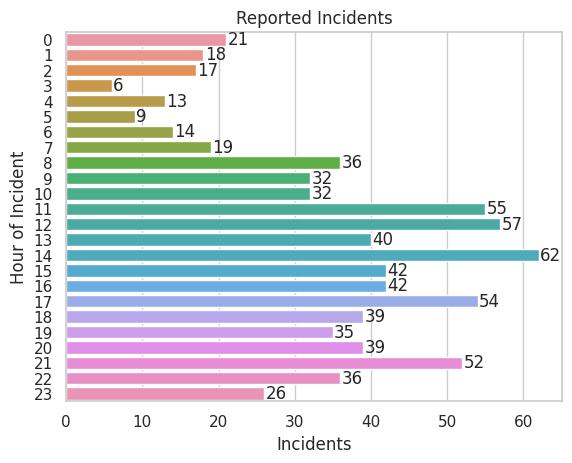

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.countplot(data=ii_df, y='doi_hour')#, order=ii_df['doi_hour'].value_counts().index)

p = plt.title('Reported Incidents')
p = plt.xlabel('Incidents')
p = plt.ylabel('Hour of Incident')

for p in g.patches:
    g.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
               ha='left', va='center', xytext=(1, 0), textcoords='offset points')

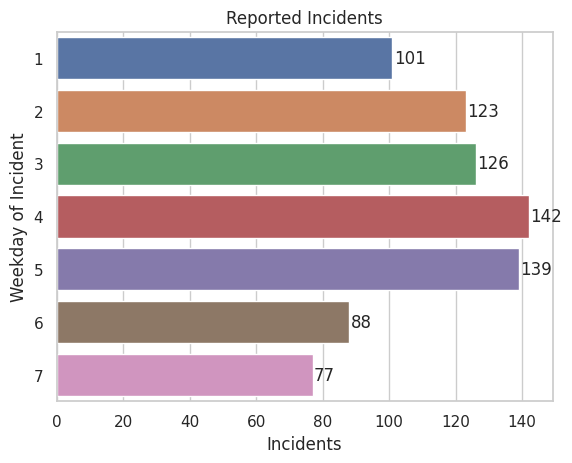

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.countplot(data=ii_df, y='doi_weekday')#, order=ii_df['doi_weekday'].value_counts().index)

p = plt.title('Reported Incidents')
p = plt.xlabel('Incidents')
p = plt.ylabel('Weekday of Incident')

for p in g.patches:
    g.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
               ha='left', va='center', xytext=(1, 0), textcoords='offset points')

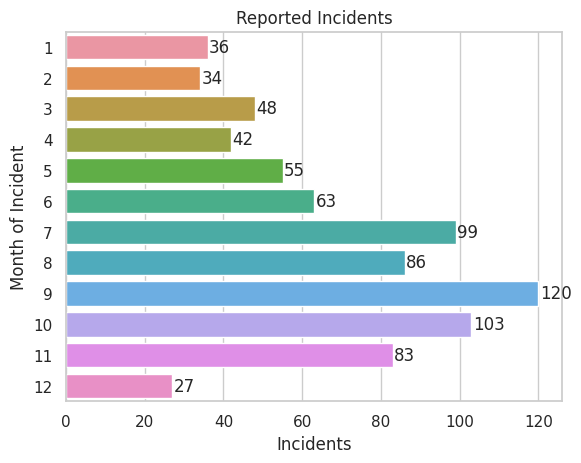

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.countplot(data=ii_df, y='doi_month')#, order=ii_df['doi_month'].value_counts().index)

p = plt.title('Reported Incidents')
p = plt.xlabel('Incidents')
p = plt.ylabel('Month of Incident')

for p in g.patches:
    g.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
               ha='left', va='center', xytext=(1, 0), textcoords='offset points')

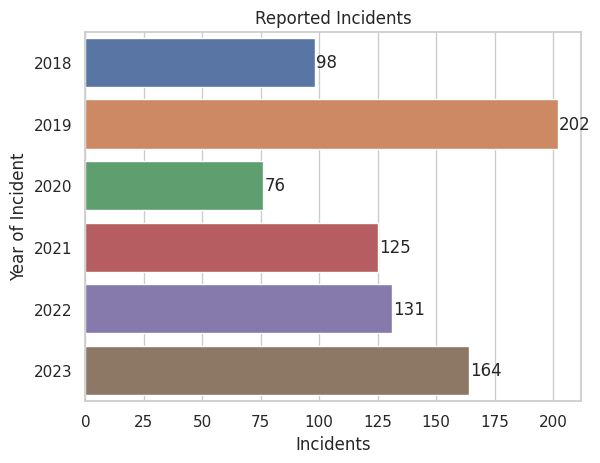

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.countplot(data=ii_df, y='doi_year')#, order=ii_df['doi_year'].value_counts().index)

p = plt.title('Reported Incidents')
p = plt.xlabel('Incidents')
p = plt.ylabel('Year of Incident')

for p in g.patches:
    g.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
               ha='left', va='center', xytext=(1, 0), textcoords='offset points')

## Cleaned Data Result

In [ ]:
ii_df.head()

,incident_url,title,date,location_of_incident,date_of_incident,date_reported,incident_details,incident,loi_standardized,extracted_streets,doi_hour,doi_weekday,doi_day,doi_month,doi_semester,doi_year
0,https://www.torontomu.ca/community-safety-secu...,Assault,"December 21, 2023",Victoria Street and Gould Street,2023-12-17 16:00:00,2023-12-17 16:00:00,TMU Security witnessed a member of the public ...,Assault,gould street and victoria street,"[gould street, victoria street]",16,7,17,12,Fall,2023
1,https://www.torontomu.ca/community-safety-secu...,Assault,"December 18, 2023",Gerrard Street East and Nelson Mandela Wak,2023-12-14 11:15:00,2023-12-14 11:15:00,A TMU community member reported to TMU Securit...,Assault,gerrard street east and nelson mandela walk,"[gerrard street east, nelson mandela walk]",11,4,14,12,Fall,2023
2,https://www.torontomu.ca/community-safety-secu...,Assault,"December 18, 2023",Victoria Street Laneway and Dundas Street East,2023-12-14 06:00:00,2023-12-14 06:00:00,A TMU community guest reported to TMU Security...,Assault,dundas street east and victoria street lane,"[dundas street east, victoria street lane]",6,4,14,12,Fall,2023
3,https://www.torontomu.ca/community-safety-secu...,Criminal Harassment,"December 13, 2023",Gould Street and Church Street,2023-12-08 23:45:00,2023-12-08 23:45:00,A TMU community member reported to TMU Securit...,Criminal Harassment,church street and gould street,"[church street, gould street]",23,5,8,12,Fall,2023
4,https://www.torontomu.ca/community-safety-secu...,Assault: Suspect Arrested,"December 13, 2023",Carlton Street and Church Street,2023-12-08 12:30:00,2023-12-08 12:30:00,Two TMU community members reported to TMU Secu...,Assault,carlton street and church street,"[carlton street, church street]",12,5,8,12,Fall,2023


# Time Series Forecasting

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = ii_df.copy(deep=True)
df = df.sort_values('date_of_incident')
df['incidents'] = 1
df['date_of_incident'] = df['date_of_incident'].dt.to_period('M').dt.to_timestamp('M')

df = df.groupby('date_of_incident')['incidents'].sum().reset_index()

In [ ]:
ts_df = df.set_index('date_of_incident')
ts_df

,incidents
date_of_incident,
2018-06-30,1
2018-07-31,11
2018-08-31,22
2018-09-30,19
2018-10-31,20
...,...
2023-08-31,10
2023-09-30,23
2023-10-31,21


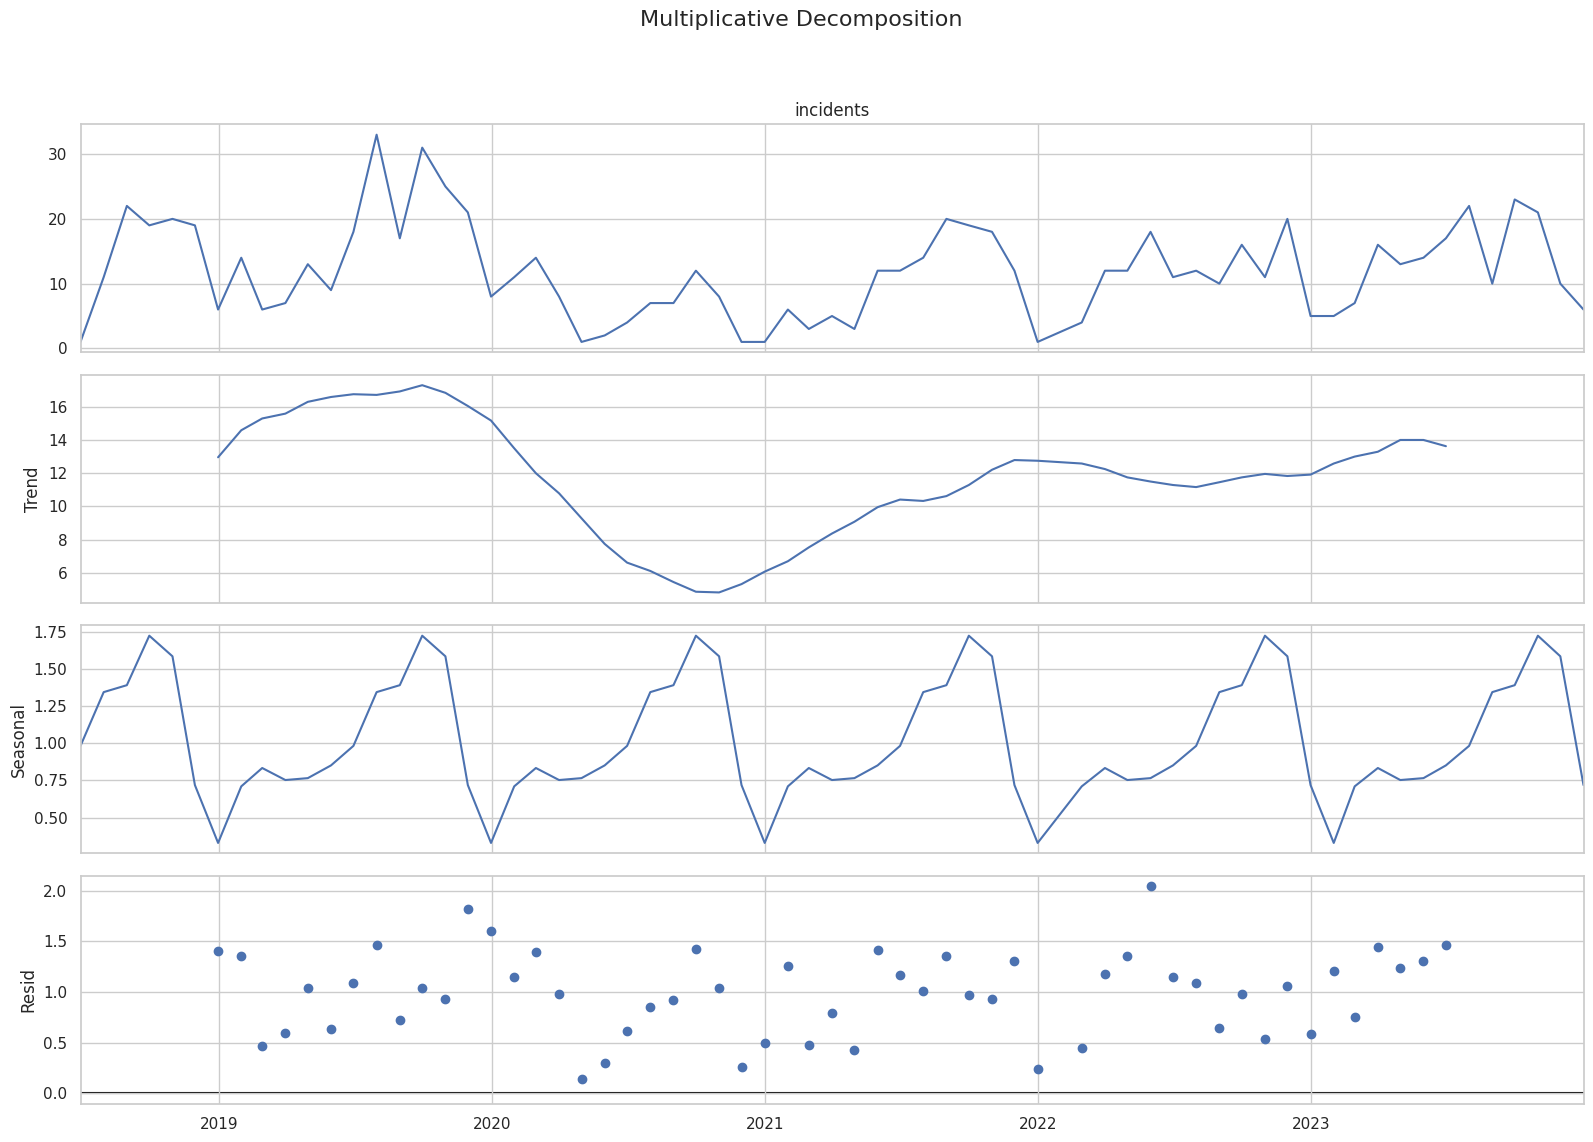

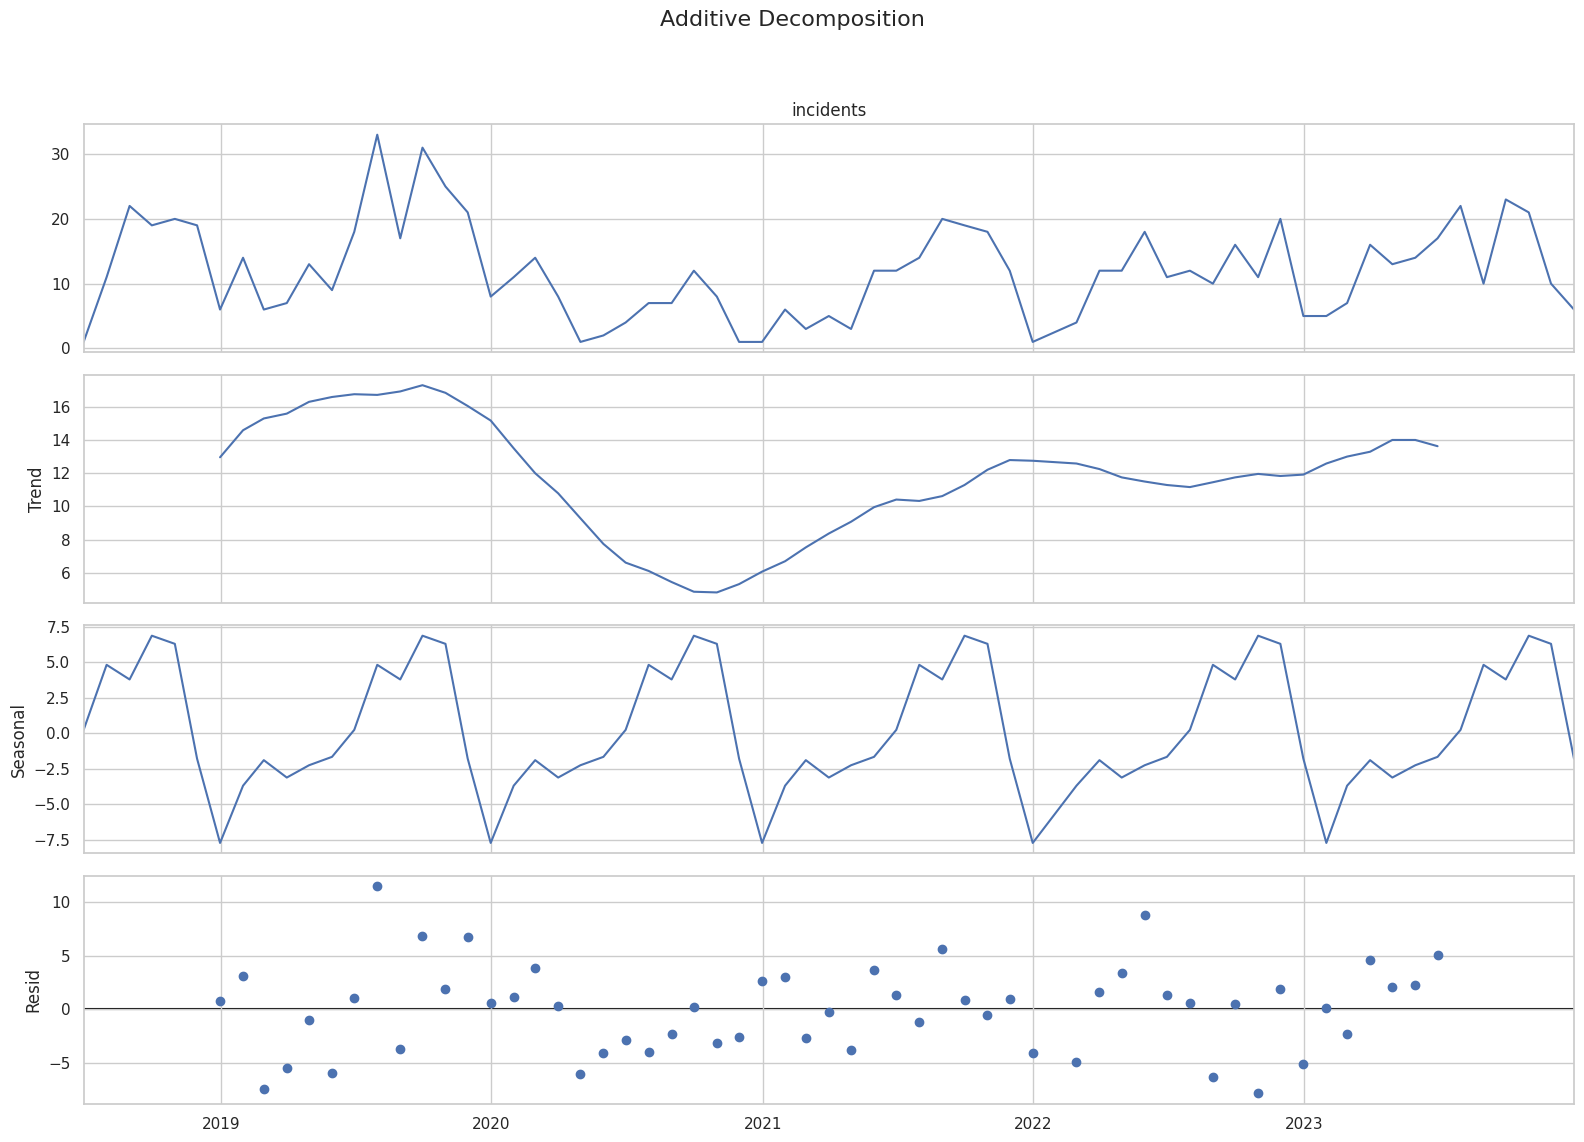

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(ts_df['incidents'], model='multiplicative', period=12)

# Additive Decomposition
additive_decomposition = seasonal_decompose(ts_df['incidents'], model='additive', period=12)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Residuals on both additive and multiplicative do not show any pattern.

The variance looks to be relatively stable over time -> additive model more suited

In [ ]:
sm.tsa.stattools.adfuller(
    ts_df['incidents'],
    maxlag=None,
    regression='c',
    autolag='AIC',
    store=False,
    regresults=False)

(-4.543619156446518,
 0.00016387319458852708,
 0,
 65,
 {'1%': -3.5352168748293127,
  '5%': -2.9071540828402367,
  '10%': -2.5911025443786984},
 353.5802562540033)

ADF statistic is -4.5577
- more negative than the critical values at the 1%, 5%, and 10% significance.
- reject the null hypothesis of a unit root

p-value is 0.0002
- below significance level of 0.05,
- reject the null hypothesis of a unit root.

The time series is already stationary.

In [ ]:
import itertools
from IPython.display import clear_output

p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
m = 12

param_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values))
scores = []

# Grid search
best_aic = float("inf")
best_params = None

for params in param_combinations:

    try:
        model = sm.tsa.SARIMAX(ts_df.asfreq('M')['incidents'], freq='M', order=(params[0], params[1], params[2]), seasonal_order=(params[3], params[4], params[5], m))
        results = model.fit()
        aic = results.aic

        scores.append(aic)

        if aic < best_aic:
            best_aic = aic
            best_params = params

    except Exception as e:
        continue

clear_output()

print("Best AIC:", best_aic)
print("Best Parameters:", best_params)


Best AIC: 356.52965018924834
Best Parameters: (2, 1, 0, 0, 1, 1)


array([[<Axes: title={'center': '0'}>]], dtype=object)

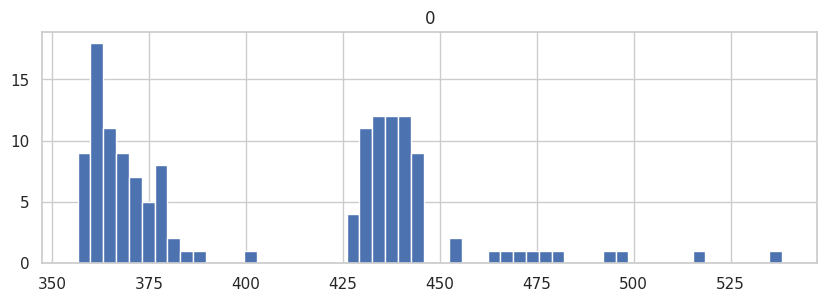

In [ ]:
pd.DataFrame(scores).hist(bins=55, figsize=[10,3])

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = sm.tsa.ARIMA(ts_df.asfreq('M')['incidents'], freq='M', order=(2, 1, 0), seasonal_order=(0, 1, 1, 12))
results = model.fit()

forecast_steps = 12  # adjust as needed
future_forecast = results.get_forecast(steps=forecast_steps)
forecast_values = np.ceil(future_forecast.predicted_mean)
forecast_df = pd.DataFrame(forecast_values).rename(columns={"predicted_mean": "incidents"})
with_forecast = pd.concat([ts_df, forecast_df])

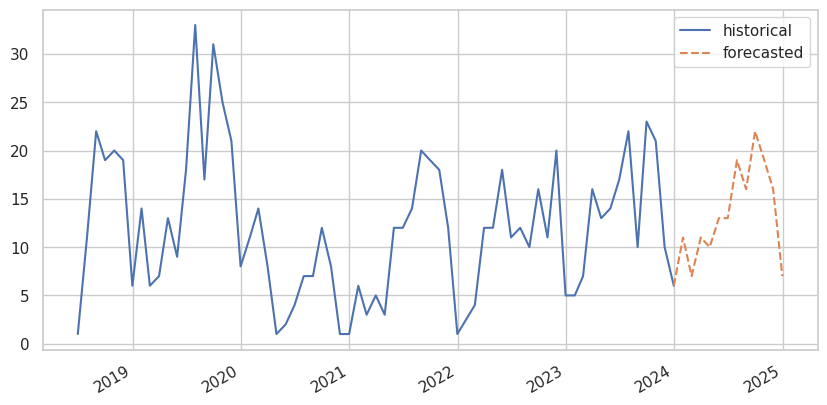

In [ ]:
df = with_forecast

forecast_start = '2023-12-31'

df_before = df.loc[df.index <= forecast_start]
df_after = df.loc[df.index >= forecast_start]

ax = df_before.plot(figsize=[10,5])
df_after.plot(ax=ax, linestyle='--')

ax.legend(['historical', 'forecasted'])

plt.show()

# (WIP) Feature Engineering and NLP Prep

In [ ]:
details_arrest = ii_df['incident_details'].apply(lambda x: 'arrest' in x.lower()) # arresting + advising of an arrest?
title_arrest = ii_df['title'].apply(lambda x: 'arrest' in x.lower())
ii_df['arrest_as_of_report'] = title_arrest | details_arrest

In [ ]:
!pip install spacy
import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

## Breaking down complex sentences

In [ ]:
import string
import re
from tqdm.notebook import tqdm
tqdm.pandas()

def clean_text(text):
    for c in string.punctuation.replace('.', ''):
        text = text.replace(c, '')

    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)

    return text

def encode_entities(text):
    entity_mappings = {
        'toronto metropolitan university': 'tmu',

        'tmu community members': 'TMU_MEMBER',
        'tmu community member': 'TMU_MEMBER',
        'ryerson community members': 'TMU_MEMBER',
        'ryerson community member': 'TMU_MEMBER',
        'community members': 'TMU_MEMBER',
        'community member': 'TMU_MEMBER',

        'tmu community guests': 'TMU_GUEST',
        'tmu community guest': 'TMU_GUEST',
        'ryerson community guests': 'TMU_GUEST',
        'ryerson community guest': 'TMU_GUEST',
        'community guests': 'TMU_GUEST',
        'community guest': 'TMU_GUEST',

        'tmu security': 'TMU_SECURITY',
        'ryerson security': 'TMU_SECURITY',
        'security': 'TMU_SECURITY',

        'members of the public': 'MEMBER_OF_THE_PUBLIC',
        'member of the public': 'MEMBER_OF_THE_PUBLIC',
        'members of public': 'MEMBER_OF_THE_PUBLIC',
        'member of public': 'MEMBER_OF_THE_PUBLIC',

        'individual' : 'INDIVIDUAL',
        'individuals' : 'INDIVIDUAL',

        'toronto police services': 'TORONTO_POLICE_SERVICES',
        'toronto police service': 'TORONTO_POLICE_SERVICES',
        'toronto police': 'TORONTO_POLICE_SERVICES',
        ' tps ': ' TORONTO_POLICE_SERVICES ',
        'police officers': 'TORONTO_POLICE_SERVICES',
        'police officer': 'TORONTO_POLICE_SERVICES',
        'police': 'TORONTO_POLICE_SERVICES',
        'officers': 'TORONTO_POLICE_SERVICES',
        'officer': 'TORONTO_POLICE_SERVICES',

        'toronto paramedic services': 'TORONTO_PARAMEDIC_SERVICES',
        'toronto paramedic service': 'TORONTO_PARAMEDIC_SERVICES',
        'paramedics': 'TORONTO_PARAMEDIC_SERVICES',
        'paramedic': 'TORONTO_PARAMEDIC_SERVICES',
    }

    for entity, code in entity_mappings.items():
        text = text.replace(entity, code)

    return text

def preprocess_text(text):
    doc = nlp(text)
    return [str(token.lemma_) for token in doc if not token.is_stop]

def break_into_phrases(text):

    sentences = text.split('.')
    sentences = [s.strip() for s in sentences if s != '']
    results = []

    for i, sentence in enumerate(sentences):
        doc = nlp(sentence)

        phrase = []
        entity_found = 0
        verb_found = 0

        sentence_entities = []
        sentence_verbs = []
        sentence_conjuctions = []

        sentence_ref = []

        for token in doc:
            str_token = str(token)
            if str_token == str_token.upper():
                sentence_entities.append(token.i)
                sentence_ref.append(['ENTITY', str_token])
            elif token.pos_ == 'VERB' or str_token in ['spat']: # spat is not recognized, not in the nltk browns top 100_000 freg verbs?
                sentence_verbs.append(token.i)
                sentence_ref.append(['VERB', str_token])
            elif token.pos_ == 'CCONJ':
                sentence_conjuctions.append(token.i)
                sentence_ref.append(['CONJ', str_token])
            else:
                sentence_ref.append(['', str_token])

        entity_cnt = len(sentence_entities)
        verb_cnt = len(sentence_verbs)
        conj_cnt = len(sentence_conjuctions)
        # print(sentence_ref)

        if not sentence_verbs:
            print(sentence_ref)

        if entity_cnt >= 2 and min(sentence_verbs) > max(sentence_entities):
            phrase = doc[min(sentence_entities):max(sentence_verbs)+1]
            phrase_ref = sentence_ref[min(sentence_entities):max(sentence_verbs)+1]
            ver = 'minE_maxV'
        elif entity_cnt >= 2:
            end_index = max(sentence_entities)
            if end_index+1 < len(doc) and sentence_ref[end_index+1][0] == 'VERB':
                end_index += 1
            phrase = doc[min(sentence_entities):end_index+1]
            phrase_ref = sentence_ref[min(sentence_entities):end_index+1]
            ver = 'minE_maxE'
        else:
            if sentence_verbs and sentence_entities:
                phrase = doc[min(sentence_entities):min(sentence_verbs)+1]
                phrase_ref = sentence_ref[min(sentence_entities):min(sentence_verbs)+1]
            else:
                phrase = doc[0:len(doc)-1]
                phrase_ref = sentence_ref[0:len(doc)-1]
            ver = 'minE_minV'

        # for i in sentence_conjuctions:
        #     prev_is_entity = i-1 in sentence_entities
        #     next_is_entity = i+1 in sentence_entities

        phrases = []

        # entity1 ... verb1 but ... verb2
        # -> entity1 ... verb1
        # -> entity1 ... verb2
        for i in range(len(phrase_ref) - 2):
            i0_pos, i0_str = phrase_ref[i]
            i1_pos, i1_str = phrase_ref[i+1]
            i2_pos, i2_str = phrase_ref[i+2]
            i1_is_but = i1_str == 'but'
            if i1_is_but:
                s1 = phrase[:i+1]
                s2 = f"{phrase[0]} {phrase[i+2:]}"
                phrases.append(s1)
                phrases.append(s2)
                break

        # entity1 ... verb1 and entity2 ...
        # -> entity1 ... verb1

        # entity1 and entity2 ... verb1
        # -> entity1 ... verb1
        # -> entity2 ... verb1
        for i in range(len(phrase_ref) - 2):
            i0_pos, i0_str = phrase_ref[i]
            i1_pos, i1_str = phrase_ref[i+1]
            i2_pos, i2_str = phrase_ref[i+2]

            i0_is_entity = i0_pos == 'ENTITY'
            i1_is_AND = i1_str == 'and'
            i2_is_entity = i2_pos == 'ENTITY'

            if all([i0_is_entity, i1_is_AND, i2_is_entity]):
                s1 = f"{phrase[i]} {phrase[i+3:]}"
                s2 = phrase[i+2:]
                phrases.append(s1)
                phrases.append(s2)
                break

        if not phrases:
            phrases.append(phrase)

        for phrase in phrases:
            if len(phrase) != 0:
                results.append(phrase)

    # return sentences, results
    results = [str(x) for x in results]
    return results

def extract_entity2entity(text):
    words = text.split(' ')
    entity_cnt = 0
    extracted_text = []

    for word in words:
        if word == word.upper():
            extracted_text.append(word)
            entity_cnt += 1
        elif entity_cnt > 0:
            extracted_text.append(word)

        if entity_cnt == 2:
            break

    if not extracted_text:
        return text

    return ' '.join(extracted_text)

ii_df2 = ii_df.copy(deep=True)

ii_df2['id_processed'] = ii_df2['incident_details'].progress_apply(clean_text)
ii_df2['id_processed'] = ii_df2['id_processed'].progress_apply(encode_entities)
ii_df2['id_phrases'] = ii_df2['id_processed'].progress_apply(break_into_phrases)
ii_df2['id_short_phrases'] = ii_df2['id_phrases'].progress_apply(lambda x: [extract_entity2entity(p) for p in x])


  0%|          | 0/796 [00:00<?, ?it/s]

  0%|          | 0/796 [00:00<?, ?it/s]

  0%|          | 0/796 [00:00<?, ?it/s]

  0%|          | 0/796 [00:00<?, ?it/s]

In [ ]:
ii_df2[['incident_details', 'id_processed', 'id_phrases', 'id_short_phrases']].head()

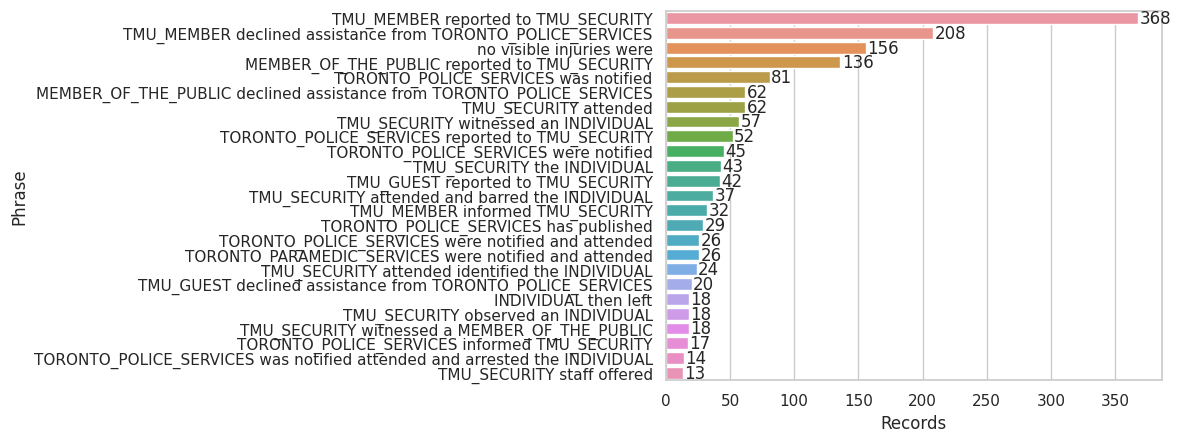

In [ ]:
phrases_df = ii_df2.explode('id_short_phrases')

sns.set_theme(style="whitegrid")

g = sns.countplot(data=phrases_df, y='id_short_phrases', order=phrases_df['id_short_phrases'].value_counts().index[:25])

# p = plt.title('Reported Incidents')
p = plt.xlabel('Records')
p = plt.ylabel('Phrase')

for p in g.patches:
    g.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
               ha='left', va='center', xytext=(1, 0), textcoords='offset points')

## break_into_phrases() testing

In [ ]:
# def break_into_phrases(text):

# TEST = "a TMU_MEMBER reported to TMU_SECURITY an individual impeded their ability to enter a building telling them they could not enter without their permission. the TMU_MEMBER was able to enter the building using their onecard and was not followed but did notice the individual blowing kisses at them. TMU_SECURITY attended but the individual had already left campus. the TMU_MEMBER declined assistance from TORONTO_POLICE_SERVICES."
# TEST = ii_df2.sample(1, random_state=3544235)['id_processed'].values[0]
# TEST = ii_df2.iloc[107]['id_processed']
# TEST = ii_df2.iloc[320]['id_processed']
# TEST = ii_df2.iloc[33]['id_processed']

# TEST = "a TMU_MEMBER reported to TMU_SECURITY that an individual approached them and punched them on the back of their head and then left the area. no visible injuries were reported. the TMU_MEMBER declined assistance from TORONTO_POLICE_SERVICES."

# x, y = break_into_phrases(TEST)

# for a, b in enumerate(x):
#     print(f"{a} - {b}")
# print()
# for a, b in enumerate(y):
#     print(f"{a} - {b}")

# TORONTO_POLICE_SERVICES and TORONTO_PARAMEDIC_SERVICES were notified and attended
# if no words



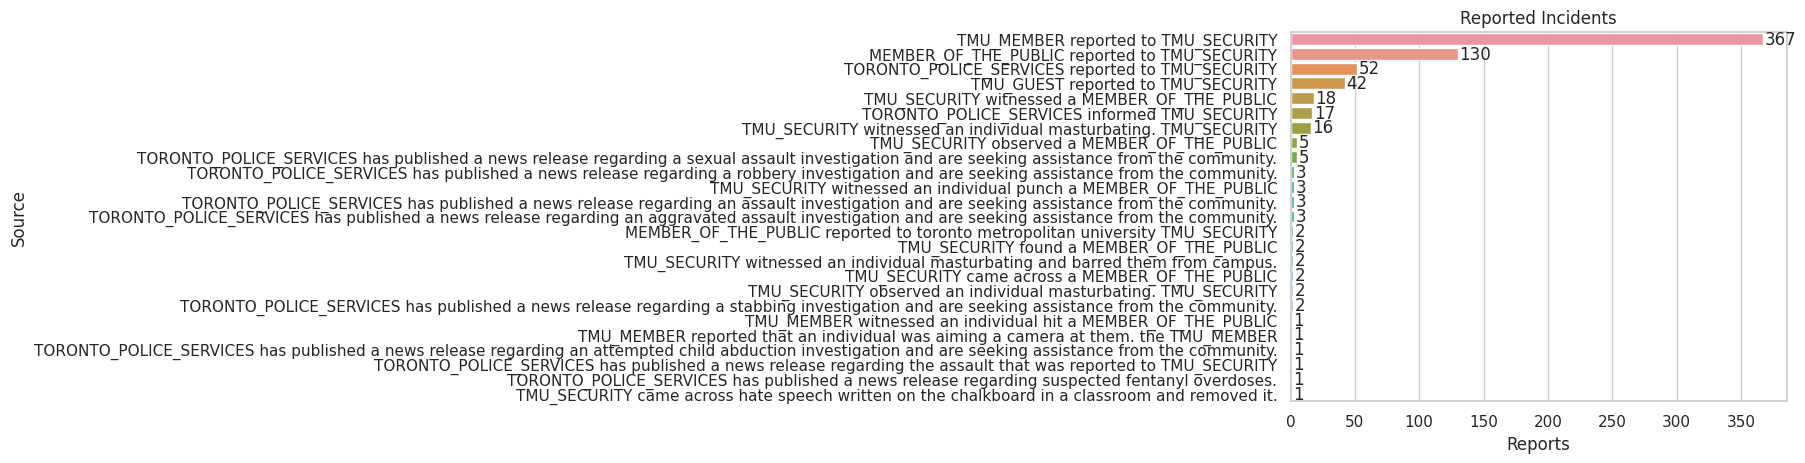

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.countplot(data=ii_df2, y='report_source', order=ii_df2['report_source'].value_counts().iloc[:25].index)

p = plt.title('Reported Incidents')
p = plt.xlabel('Incidents')
p = plt.ylabel('Source')

for p in g.patches:
    g.annotate(f'{p.get_width():.0f}', (p.get_width(), p.get_y() + p.get_height() / 2),
               ha='left', va='center', xytext=(1, 0), textcoords='offset points')

## n-grams

In [ ]:
corpus_text = '. '.join(df['ii_processed'])
sentences = corpus_text.split('. ')

In [ ]:
from nltk import ngrams
from collections import Counter
import re

def calculate_ngram_frequencies(text, n):
    cumulative_ngram_freq = Counter()

    for sentence in sentences:

        sentence = sentence.replace('.', '')

        words = sentence.split()

        # Generate n-grams
        ngrams_list = list(ngrams(words, n))

        # Update the cumulative n-gram frequency counter
        cumulative_ngram_freq.update(ngrams_list)

    return cumulative_ngram_freq


cumulative_bigram_freq = calculate_ngram_frequencies(sentences, 2)
cumulative_quadgram_freq = calculate_ngram_frequencies(sentences, 4)

# Print the results
print("Cumulative Bigram Frequencies:")
for bigram, freq in cumulative_bigram_freq.most_common(250):
    if (bigram[0] == bigram[0].upper() or bigram[1].endswith('ed')) and bigram[0] not in ['and']:
        print(bigram, ":", freq)

print("\nCumulative Quadgram Frequencies:")
for trigram, freq in cumulative_quadgram_freq.most_common(250):
    if trigram[0] == trigram[0].upper() and freq > 1:
        print(trigram, ":", freq)

Cumulative Bigram Frequencies:
('TMU_SECURITY', 'that') : 601
('TMU_MEMBER', 'reported') : 331
('DECLINED_ASSISTANCE', 'from') : 309
('individual', 'approached') : 209
('TMU_MEMBER', 'DECLINED_ASSISTANCE') : 183
('were', 'reported') : 162
('TMU_SECURITY', 'attended') : 151
('MEMBER_OF_THE_PUBLIC', 'reported') : 129
('TORONTO_POLICE_SERVICES', 'was') : 104
('TMU_SECURITY', 'witnessed') : 83
('was', 'notified') : 83
('were', 'notified') : 79
('TORONTO_POLICE_SERVICES', 'were') : 67
('MEMBER_OF_THE_PUBLIC', 'DECLINED_ASSISTANCE') : 60
('MEMBER_OF_THE_PUBLIC', 'was') : 59
('TMU_SECURITY', 'attended,') : 56
('TORONTO_POLICE_SERVICES', 'reported') : 53
('TMU_MEMBERS', 'reported') : 47
('TMU_SECURITY', 'they') : 43
('TMU_GUEST', 'reported') : 36
('TORONTO_POLICE_SERVICES', 'and') : 36
('individual', 'followed') : 34
('they', 'witnessed') : 34
('TMU_MEMBER', 'informed') : 32
('TORONTO_POLICE_SERVICES', 'has') : 32
('has', 'published') : 32
('MEMBER_OF_THE_PUBLIC', 'sustained') : 31
('individua

# Dashboard Visuals

In [ ]:
!pip install -U altair
!pip install -U pyarrow
!pip install vega_datasets

import pandas as pd
import altair as alt
from vega_datasets import data
import ast

In [ ]:
dashboard_data = pd.read_csv('dashboard_data.csv')
dashboard_data['extracted_streets'] = dashboard_data['extracted_streets'].apply(ast.literal_eval)
dashboard_data['date_of_incident'] = pd.to_datetime(dashboard_data['date_of_incident'])

incident_selection = alt.selection_point(fields=['incident'], on='click', nearest=True)
location_selection = alt.selection_point(fields=['loi_standardized'], on='click', nearest=True)
month_wday_selection = alt.selection_point(encodings=['x', 'y'])
month_wday_highlight = alt.selection_point()
streets_selection = alt.selection_point(encodings=['x', 'y'])
streets_highlight = alt.selection_point()
doi_interval_selection = alt.selection_interval()

data = dashboard_data.copy(deep=True)
data2 = data.copy(deep=True)

# exploding the list of streets into rows, then split into columns
street_combos = data['extracted_streets'].apply(lambda x: [[x[0], x[-1]], [x[-1], x[0]]])
data_df = pd.DataFrame(street_combos.explode())
data_df[['street_x', 'street_y']] = data_df['extracted_streets'].apply(pd.Series)
data_df.drop('extracted_streets', axis=1, inplace=True)
data = data2.join(data_df)

incidents_by_month = alt.Chart(data).mark_line(point=True).encode(
    x=alt.X('yearmonth(date_of_incident):N', title='Date of Incident'),
    y=alt.Y('distinct(incident_url):Q', title='Reported Incidents'),
    text='distinct(incident_url):Q',
    tooltip=[
        alt.Tooltip('distinct(incident_url):Q', title='Reported Incidents'),
        alt.Tooltip('yearmonth(date_of_incident):N', title='Date of Incident'),
        alt.Tooltip('doi_semester:N', title='Semester of Incident'),
    ],
).add_params(
    doi_interval_selection
).properties(
    title='Monthly Incidents',
    width=880,
    height=280,
)

month_wday_heatmap = alt.Chart(data).mark_rect().encode(
    x=alt.X('day(date_of_incident):O').title('Weekday of Incident'),
    y=alt.Y('month(date_of_incident):O').title('Month of Incident'),
    # color=alt.Color('distinct(incident_url):Q', title=''),
    color=alt.condition(month_wday_selection, 'distinct(incident_url):Q', alt.value('lightgrey'), title=''),
    tooltip=[
        alt.Tooltip('distinct(incident_url):Q', title='Reported Incidents'),
        alt.Tooltip('month(date_of_incident):N', title='Month of Incident'),
        alt.Tooltip('day(date_of_incident):N', title='Weekday of Incident'),
    ],
).add_params(
    month_wday_selection
).transform_filter(
    incident_selection
).transform_filter(
    doi_interval_selection
).transform_filter(
    location_selection
).transform_filter(
    streets_selection
).properties(
    title='Month & Weekday of Incident',
    width=400,
    height=280,
)

incident_type_bar = alt.Chart(data).mark_bar().encode(
    x=alt.X('distinct(incident_url):Q', title='Reported Incidents'),
    y=alt.Y('incident:N', title='', axis=alt.Axis(labelLimit=200)).sort('-x'),
    color=alt.condition(incident_selection, 'incident:N', alt.value('lightgrey')),
    text='distinct(incident_url):Q',
    tooltip=[
        alt.Tooltip('distinct(incident_url):Q', title='Reported Incidents'),
        alt.Tooltip('incident:N', title='Incident Type'),
    ],
).add_params(
    incident_selection
).transform_filter(
    doi_interval_selection
).transform_filter(
    location_selection
).transform_filter(
    month_wday_selection
).transform_filter(
    streets_selection
).properties(
    title='Type of Incident',
    width=200,
    height=490,
)

incident_type_by_hour = alt.Chart(data).mark_bar().encode(
    x=alt.X('distinct(incident_url):Q', title=''),
    y=alt.Y('hours(date_of_incident):N', title=''),
    color=alt.Color('distinct(incident_url):Q', title=''),
    text='distinct(incident_url):Q',
    tooltip=[
        alt.Tooltip('distinct(incident_url):Q', title='Reported Incidents'),
        alt.Tooltip('hours(date_of_incident):N', title='Hour of Incident'),
    ],
).transform_filter(
    incident_selection
).transform_filter(
    doi_interval_selection
).transform_filter(
    location_selection
).transform_filter(
    month_wday_selection
).transform_filter(
    streets_selection
).properties(
    title='Hour of Incident',
    width=150,
    height=490
)

incident_type_by_month = alt.Chart(data).mark_bar().encode(
    x=alt.X('distinct(incident_url):Q', title=''),
    y=alt.Y('month(date_of_incident):N', title=''),
    color=alt.Color('distinct(incident_url):Q', title=''),
    text='distinct(incident_url):Q',
    tooltip=[
        alt.Tooltip('distinct(incident_url):Q', title='Reported Incidents'),
        alt.Tooltip('month(date_of_incident):N', title='Month of Incident'),
        alt.Tooltip('doi_semester:N', title='Semester of Incident'),
    ],
).transform_filter(
    incident_selection
).transform_filter(
    doi_interval_selection
).transform_filter(
    location_selection
).transform_filter(
    month_wday_selection
).transform_filter(
    streets_selection
).properties(
    title='Month of Incident',
    width=150,
    height=490
)

incident_type_by_year = alt.Chart(data).mark_bar().encode(
    x=alt.X('distinct(incident_url):Q', title=''),
    y=alt.Y('year(date_of_incident):N', title=''),
    color=alt.Color('distinct(incident_url):Q', title=''),
    text='distinct(incident_url):Q',
    tooltip=[
        alt.Tooltip('distinct(incident_url):Q', title='Reported Incidents'),
        alt.Tooltip('year(date_of_incident):N', title='Year of Incident'),
    ],
).transform_filter(
    incident_selection
).transform_filter(
    doi_interval_selection
).transform_filter(
    location_selection
).transform_filter(
    month_wday_selection
).transform_filter(
    streets_selection
).properties(
    title='Year of Incident',
    width=150,
    height=490
)


incidents_by_loc_base = alt.Chart(data).mark_bar().encode(
    y=alt.Y('distinct(incident_url):Q', title='Reported Incidents'),
    x=alt.X('loi_standardized:N', title='', axis=alt.Axis(labelLimit=200)).sort('-y'),
).add_params(
    location_selection
).transform_filter(
    incident_selection
).transform_filter(
    doi_interval_selection
).transform_filter(
    month_wday_selection
).transform_filter(
    streets_selection
).properties(
    title='Location of Incident',
    width=1100,
    height=300,
)

incidents_by_loc = incidents_by_loc_base.encode(
    color=alt.condition(location_selection, 'incident:N', alt.value('lightgrey'), legend=None),
    tooltip=[
        alt.Tooltip('distinct(incident_url):Q', title='Reported Incidents'),
        alt.Tooltip('loi_standardized:N', title='Location of Incident'),
        alt.Tooltip('incident:N', title='Incident Type'),
    ],
)

incidents_by_loc_text = incidents_by_loc_base.encode(
    text='distinct(incident_url):Q',
)

streets_chart = alt.Chart(data).mark_rect().encode(
    x=alt.X('street_x:O', title=''),
    y=alt.Y('street_y:O', title=''),
    color=alt.Color('distinct(incident_url):Q', title=''),
    tooltip=[
        alt.Tooltip('distinct(incident_url):Q', title='Reported Incidents'),
        alt.Tooltip('loi_standardized:N', title='Location of Incident'),
    ],
).properties(
    title='Street Intersections Reported As Location of Incident',
    width=490,
    height=490,
).add_params(
    streets_selection
).transform_filter(
    (alt.datum.street_x != 'building') & (alt.datum.street_y != 'building')
).transform_filter(
    incident_selection
).transform_filter(
    location_selection
).transform_filter(
    doi_interval_selection
).transform_filter(
    month_wday_selection
)


incident_type_bar = incident_type_bar + incident_type_bar.mark_text(align='left', dx=3)
incidents_by_loc = incidents_by_loc + incidents_by_loc_text.mark_text(align='center', dy=-6)

row_1 = incidents_by_month | month_wday_heatmap
row_2 = incident_type_bar | incidents_by_loc
row_3 = incident_type_by_hour | incident_type_by_month | incident_type_by_year | streets_chart

row_1 & row_2 & row_3.resolve_scale(
    color='independent'
)



alt.VConcatChart(...)